In [1]:
import requests
import csv
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'bright', 'cjk-jp-font', 'cjk-kr-font', 'cjk-sc-font', 'cjk-tc-font', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'grid', 'high-contrast', 'high-vis', 'ieee', 'light', 'muted', 'no-latex', 'notebook', 'notebook0', 'pgf', 'retro', 'scatter', 'science', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'std-colors', 'tableau-colorblind10', 'vibrant']


## Select landing, month, year

In [2]:
landing_dic = {'Fishermans':['fishermans_landing','22'],\
          'Seaforth':['seaforth_sportfishing','20'],\
           'Point loma':['point_loma_sportfishing','23']}
fish_kinds = ['Bluefin','Yellowfin','Yellowtail','Dorado','Calico Bass','Rockfish']
month = [6,7,8,9,10,11]
fsize = (15, 15)

#### Grab data for YYYY-MM

In [3]:
def get_df_yyyymm(year,month,landing):
    month = str(month)
    year = str(year)
    URL = 'https://www.sandiegofishreports.com/landings/'+landing[0]+'.php?landing_id='+landing[1]+'&month='+month+'&year='+year+'#historicals'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content,'html.parser')
    tb_set = soup.find_all('tbody')
    # first table is daily landing counts
    table_daily = tb_set[0]
    # tr finds table rows
    rows = table_daily.find_all('tr') 
    rows = rows[2:-1]

    df = pd.DataFrame(columns = ['Date', 'Boats', 'Anglers','Fish count'])
    for row in rows:
        row_text = row.text.split('\n')
        rwo_text = row_text[1:-1] # remove top and bottom row
        date_text = rwo_text[0].split() # convert "June" to "Jun"
        date_text = date_text[0][:3] + ' ' + date_text[1] + ' ' + date_text[2] # convert "June" to "Jun"
        trip_stats = [datetime.strptime(date_text, '%b %d, %Y')]
        for item in rwo_text[1:3]:
            trip_stats.append(int(item.split()[0]))
        trip_stats.append(rwo_text[-1])
        df.loc[len(df.index)] = trip_stats # append [date,boats,angs,fish]
        
    return df

#### Process fish count

In [4]:
def proc_fish_count(df):
    # fish_kinds = ['Bluefin','Yellowfin','Yellowtail','Bonito',...
    #               'Barracuda','Sheephead','Calico Bass',...
    #               'Barred Sand Bass','Rockfish','Whitefish']
    # fish_dict = {'Bluefin':'bl','Yellowfin':'yellowf','Yellowtail':'yellowt','Bonito':'bon',...
    #               'Barracuda':'barra','Sheephead':'sh','Calico Bass':'cal',...
    #               'Barred Sand Bass':'barre','Rockfish':'ro','Whitefish':'wh'}
    fish_kinds = ['Bluefin','Yellowfin','Yellowtail','Dorado','Bonito',
                  'Sheephead','Calico Bass','Rockfish']
    fish_dict = {'Bluefin':'bl','Yellowfin':'yellowf','Yellowtail':'yellowt','Dorado':'dor','Bonito':'bon',
                 'Sheephead':'sh','Calico Bass':'cal','Rockfish':'ro'}
    # add new col
    for col in fish_kinds:
        df[col] = 0
    for ii in range(len(df.index)):
        fish_text = df['Fish count'][ii].lower()
        fish_text_s = fish_text.split(', ')
        for fish_name in fish_kinds:
            if fish_dict[fish_name] in fish_text:
                a = [s for s in fish_text_s if fish_dict[fish_name] in s]
                df[fish_name][ii] = int(a[0].split()[0])
    df = df.drop(columns = ['Fish count'])
    return df

## Point Loma 2019

In [5]:
landing = landing_dic['Point loma']
year = 2019

df = pd.DataFrame([]);
for mm in month:
    df = pd.concat([df,get_df_yyyymm(year,mm,landing)], axis = 0)
df = df.reset_index()
df = df.set_index('Date')
df = df.drop(columns = ['index'])

df = proc_fish_count(df)

<ipython-input-4-dcfce5cc072e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[fish_name][ii] = int(a[0].split()[0])


In [6]:
# Get moon phase
import ephem
import calendar
from math import radians as rad, degrees as deg

g = ephem.Observer()
g.name = 'Los Angeles'
g.lat=rad(34.0211)
g.long=rad(-118.3965)
m = ephem.Moon()

date_list = df.index

mphase_list = []
for ii in range(0, len(date_list)):
    g.date = date_list[ii]
    g.date -= ephem.hour
    m.compute(g)
    mphase_list.append(m.phase)

df['Moon phase'] = mphase_list
df.head()

,Boats,Anglers,Bluefin,Yellowfin,Yellowtail,Dorado,Bonito,Sheephead,Calico Bass,Rockfish,Moon phase
Date,,,,,,,,,,,
2019-06-01,2,57,0,0,0,0,0,140,6,140,7.077343
2019-06-02,4,77,40,0,0,0,0,30,5,30,2.669645
2019-06-03,1,12,6,0,0,0,0,0,0,0,0.350593
2019-06-04,1,31,62,0,0,0,0,0,0,0,0.410026
2019-06-05,1,12,0,0,0,0,0,78,0,78,3.004632


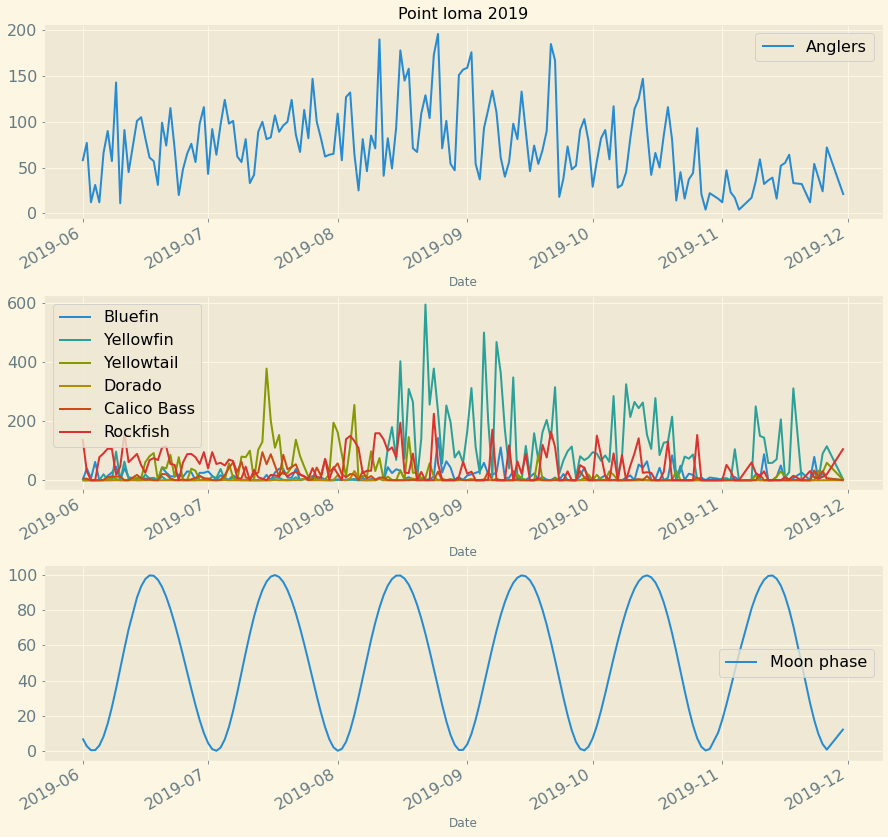

In [7]:
plt.rcParams['font.size'] = '16'
plt.style.use('Solarize_Light2')
fig, axes = plt.subplots(nrows=3, ncols=1)
df[['Anglers']].plot(ax=axes[0], figsize=fsize, title = 'Point loma 2019')
df[fish_kinds].plot(ax=axes[1],figsize=fsize)
df[['Moon phase']].plot(ax=axes[2], figsize=fsize)

plt.subplots_adjust(hspace=0.4)
plt.show()

## Fishermans 2019

<ipython-input-4-dcfce5cc072e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[fish_name][ii] = int(a[0].split()[0])


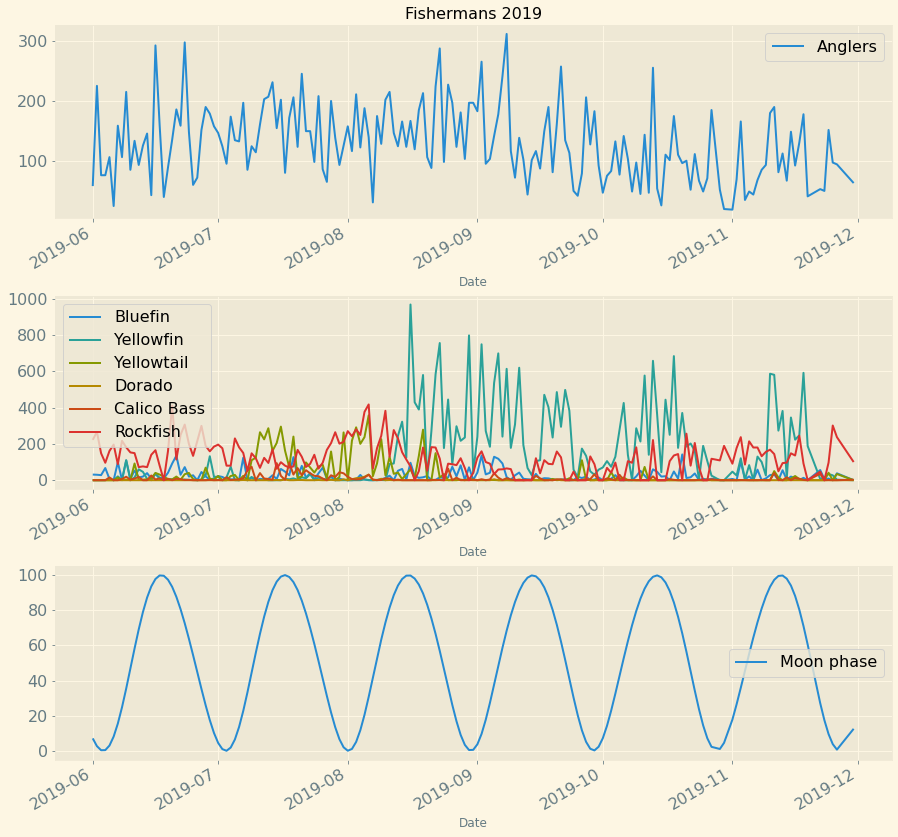

In [10]:
landing = landing_dic['Fishermans']
year = 2019

df = pd.DataFrame([]);
for mm in month:
    df = pd.concat([df,get_df_yyyymm(year,mm,landing)], axis = 0)
df = df.reset_index()
df = df.set_index('Date')
df = df.drop(columns = ['index'])

df = proc_fish_count(df)

# Get moon phase
import ephem
import calendar
from math import radians as rad, degrees as deg

g = ephem.Observer()
g.name = 'Los Angeles'
g.lat=rad(34.0211)
g.long=rad(-118.3965)
m = ephem.Moon()

date_list = df.index

mphase_list = []
for ii in range(0, len(date_list)):
    g.date = date_list[ii]
    g.date -= ephem.hour
    m.compute(g)
    mphase_list.append(m.phase)
df['Moon phase'] = mphase_list

plt.rcParams['font.size'] = '16'
plt.style.use('Solarize_Light2')
fig, axes = plt.subplots(nrows=3, ncols=1)
df[['Anglers']].plot(ax=axes[0], figsize=fsize, title = 'Fishermans 2019')
df[fish_kinds].plot(ax=axes[1],figsize=fsize)
df[['Moon phase']].plot(ax=axes[2], figsize=fsize)

plt.subplots_adjust(hspace=0.4)
plt.show()

## Seaforth 2019

<ipython-input-4-dcfce5cc072e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[fish_name][ii] = int(a[0].split()[0])


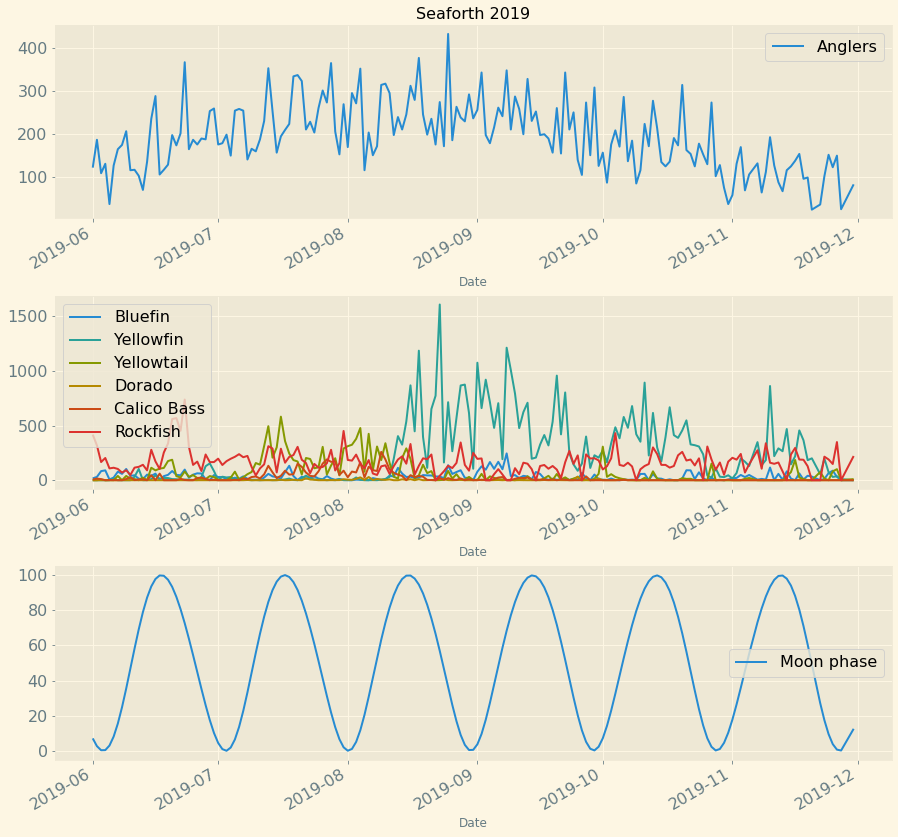

In [9]:
landing = landing_dic['Seaforth']
year = 2019

df = pd.DataFrame([]);
for mm in month:
    df = pd.concat([df,get_df_yyyymm(year,mm,landing)], axis = 0)
df = df.reset_index()
df = df.set_index('Date')
df = df.drop(columns = ['index'])

df = proc_fish_count(df)

# Get moon phase
import ephem
import calendar
from math import radians as rad, degrees as deg

g = ephem.Observer()
g.name = 'Los Angeles'
g.lat=rad(34.0211)
g.long=rad(-118.3965)
m = ephem.Moon()

date_list = df.index

mphase_list = []
for ii in range(0, len(date_list)):
    g.date = date_list[ii]
    g.date -= ephem.hour
    m.compute(g)
    mphase_list.append(m.phase)

df['Moon phase'] = mphase_list

## plot
plt.rcParams['font.size'] = '16'
plt.style.use('Solarize_Light2')
fig, axes = plt.subplots(nrows=3, ncols=1)
df[['Anglers']].plot(ax=axes[0], figsize=fsize, title = 'Seaforth 2019')
df[fish_kinds].plot(ax=axes[1],figsize=fsize)
df[['Moon phase']].plot(ax=axes[2], figsize=fsize)

plt.subplots_adjust(hspace=0.4)
plt.show()

## Seaforth 2020

<ipython-input-4-dcfce5cc072e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[fish_name][ii] = int(a[0].split()[0])


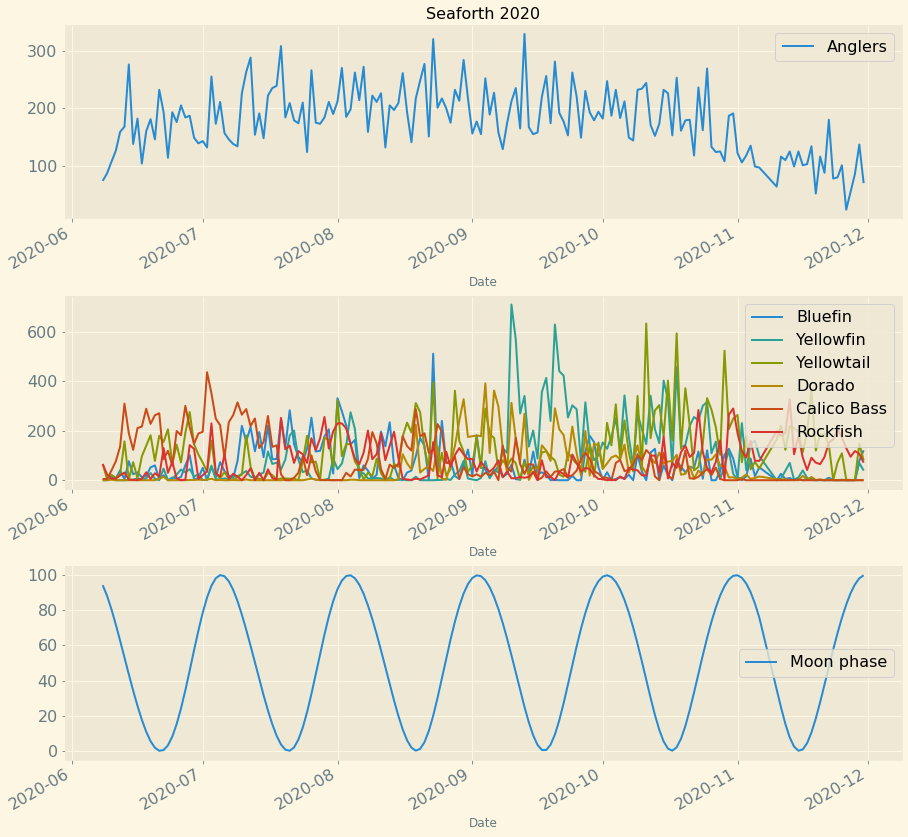

In [10]:
landing = landing_dic['Seaforth']
year = 2020

df = pd.DataFrame([]);
for mm in month:
    df = pd.concat([df,get_df_yyyymm(year,mm,landing)], axis = 0)
df = df.reset_index()
df = df.set_index('Date')
df = df.drop(columns = ['index'])

df = proc_fish_count(df)

# Get moon phase
import ephem
import calendar
from math import radians as rad, degrees as deg

g = ephem.Observer()
g.name = 'Los Angeles'
g.lat=rad(34.0211)
g.long=rad(-118.3965)
m = ephem.Moon()

date_list = df.index

mphase_list = []
for ii in range(0, len(date_list)):
    g.date = date_list[ii]
    g.date -= ephem.hour
    m.compute(g)
    mphase_list.append(m.phase)

df['Moon phase'] = mphase_list

## plot
plt.rcParams['font.size'] = '16'
plt.style.use('Solarize_Light2')
fig, axes = plt.subplots(nrows=3, ncols=1)
df[['Anglers']].plot(ax=axes[0], figsize=fsize, title = 'Seaforth 2020')
df[fish_kinds].plot(ax=axes[1],figsize=fsize)
df[['Moon phase']].plot(ax=axes[2], figsize=fsize)

plt.subplots_adjust(hspace=0.4)
plt.show()

## Seaforth 2021

<ipython-input-4-dcfce5cc072e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[fish_name][ii] = int(a[0].split()[0])


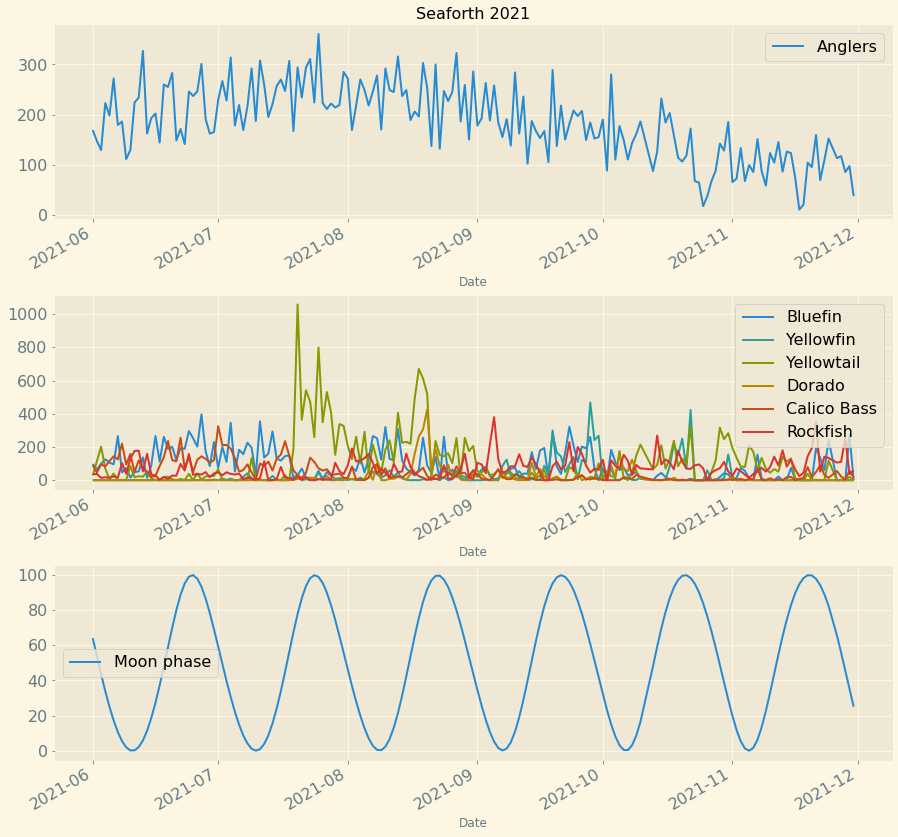

In [11]:
landing = landing_dic['Seaforth']
year = 2021

df = pd.DataFrame([]);
for mm in month:
    df = pd.concat([df,get_df_yyyymm(year,mm,landing)], axis = 0)
df = df.reset_index()
df = df.set_index('Date')
df = df.drop(columns = ['index'])

df = proc_fish_count(df)

# Get moon phase
import ephem
import calendar
from math import radians as rad, degrees as deg

g = ephem.Observer()
g.name = 'Los Angeles'
g.lat=rad(34.0211)
g.long=rad(-118.3965)
m = ephem.Moon()

date_list = df.index

mphase_list = []
for ii in range(0, len(date_list)):
    g.date = date_list[ii]
    g.date -= ephem.hour
    m.compute(g)
    mphase_list.append(m.phase)

df['Moon phase'] = mphase_list

## plot
plt.rcParams['font.size'] = '16'
plt.style.use('Solarize_Light2')
fig, axes = plt.subplots(nrows=3, ncols=1)
df[['Anglers']].plot(ax=axes[0], figsize=fsize, title = 'Seaforth 2021')
df[fish_kinds].plot(ax=axes[1],figsize=fsize)
df[['Moon phase']].plot(ax=axes[2], figsize=fsize)

plt.subplots_adjust(hspace=0.4)
plt.show()

## Seaforth 2022

<ipython-input-4-dcfce5cc072e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[fish_name][ii] = int(a[0].split()[0])


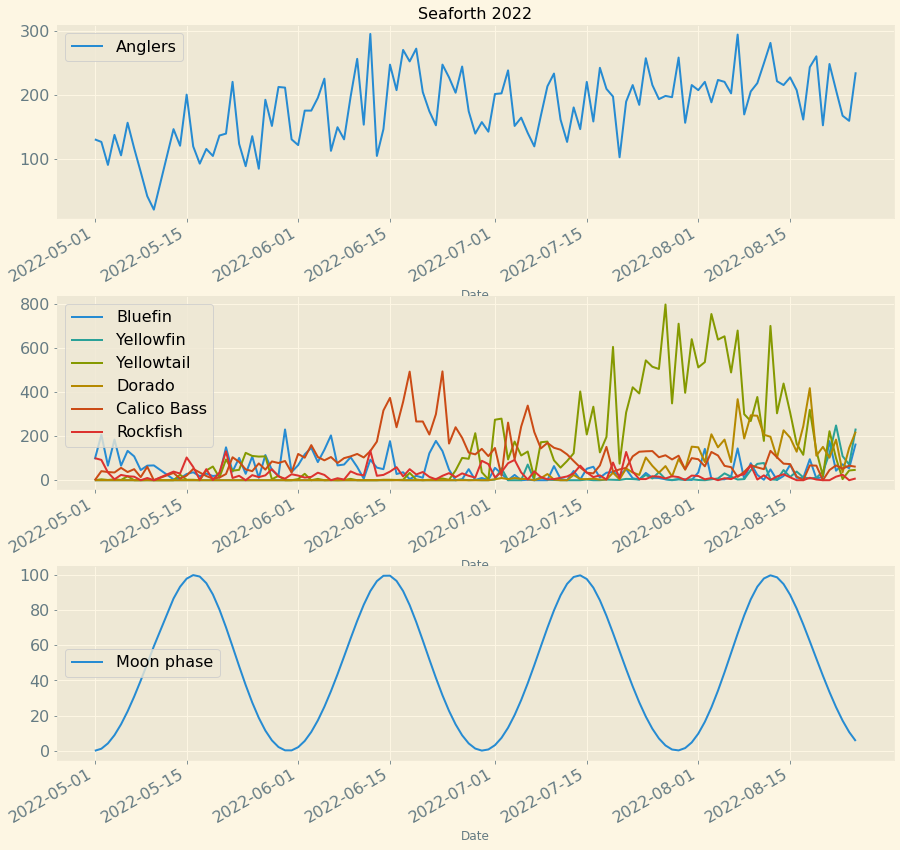

In [12]:
landing = landing_dic['Seaforth']
year = 2022
month = [5,6,7,8]

df = pd.DataFrame([]);
for mm in month:
    df = pd.concat([df,get_df_yyyymm(year,mm,landing)], axis = 0)
df = df.reset_index()
df = df.set_index('Date')
df = df.drop(columns = ['index'])

df = proc_fish_count(df)

# Get moon phase
import ephem
import calendar
from math import radians as rad, degrees as deg

g = ephem.Observer()
g.name = 'Los Angeles'
g.lat=rad(34.0211)
g.long=rad(-118.3965)
m = ephem.Moon()

date_list = df.index

mphase_list = []
for ii in range(0, len(date_list)):
    g.date = date_list[ii]
    g.date -= ephem.hour
    m.compute(g)
    mphase_list.append(m.phase)

df['Moon phase'] = mphase_list

## plot
plt.rcParams['font.size'] = '16'
plt.style.use('Solarize_Light2')
fig, axes = plt.subplots(nrows=3, ncols=1)
df[['Anglers']].plot(ax=axes[0], figsize=fsize, title = 'Seaforth 2022')
df[fish_kinds].plot(ax=axes[1],figsize=fsize)
df[['Moon phase']].plot(ax=axes[2], figsize=fsize)

plt.subplots_adjust(hspace=0.4)
plt.show()